<a href="https://colab.research.google.com/github/ggranadillo21/Mytest/blob/master/AnomalyDetection_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from numpy.random import seed
seed(1)



In [7]:
# Download the dataset
#PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
PATH_TO_DATA ='muestra1.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data = data.drop(0, axis=0)
data = data.drop(0, axis=1)
data = data.drop(12, axis=1)
data = data.drop(13, axis=1)
data.head()
#data.shape
# data shape
# (10487, 15)
#Label 1 denotes the observation as an anomaly and label 0 denotes the observation as normal.

,1,2,3,4,5,6,7,8,9,10,11,14
1,0,6,33877,443,1,66,16,0,0,10000,660000,3
2,0.042,6,80,52335,2,413,26,32,0,47.6190476190476,9833.33333333333,3
3,0.215,6,51696,80,8,1350,26,0,0,37.2093023255814,6279.06976744186,0
4,0.143,6,37251,443,4,1810,24,0,0,27.972027972028,12657.3426573427,6
5,0,6,35641,80,1,66,16,0,0,10000,660000,8


In [8]:
# 9th column is the target
# 1 = anomaly, 0 = normal

x_train = pd.read_csv("x_train.csv", header=None)
x_train = x_train.drop(0, axis=0)
x_train = x_train.drop(0, axis=1)

y_train = pd.read_csv("y_train.csv", header=None)
y_train = y_train.drop(0, axis=0)
y_train = y_train.drop(0, axis=1)

x_test = pd.read_csv("x_test.csv", header=None)
x_test = x_test.drop(0, axis=0)
x_test = x_test.drop(0, axis=1)

y_test = pd.read_csv("y_test.csv", header=None)
y_test = y_test.drop(0, axis=0)
y_test = y_test.drop(0, axis=1)

# min max scale the input data
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/50
110/110 [==============================] - 3s 18ms/step - loss: 0.2602 - accuracy: 0.6901 - val_loss: 0.1957 - val_accuracy: 0.8901
Epoch 2/50
110/110 [==============================] - 2s 15ms/step - loss: 0.1919 - accuracy: 0.9290 - val_loss: 0.1891 - val_accuracy: 0.9475
Epoch 3/50
110/110 [==============================] - 2s 15ms/step - loss: 0.1900 - accuracy: 0.9529 - val_loss: 0.1881 - val_accuracy: 0.9466
Epoch 4/50
110/110 [==============================] - 2s 17ms/step - loss: 0.1894 - accuracy: 0.9520 - val_loss: 0.1874 - val_accuracy: 0.9452
Epoch 5/50
110/110 [==============================] - 2s 15ms/step - loss: 0.1885 - accuracy: 0.9531 - val_loss: 0.1864 - val_accuracy: 0.9570
Epoch 6/50
110/110 [==============================] - 2s 16ms/step - loss: 0.1879 - accuracy: 0.9504 - val_loss: 0.1856 - val_accuracy: 0.9564
Epoch 7/50
110/110 [==============================] - 2s 15ms/step - loss: 0.1873 - accuracy: 0.9633 - val_loss: 0.1856 - val_accuracy: 0.9530

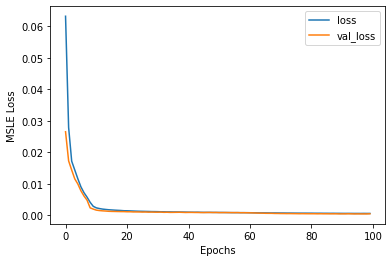

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261


Threshold: 0.0016114734212641665


In [ ]:
predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)


0.6615031554790591

In [ ]:

predictions

,class
0,1
1,1
2,1
3,1
4,1
...,...
3481,1
3482,1
3483,1
3484,1


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=750,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/750
125/125 [==============================] - 4s 9ms/step - loss: 0.2542 - accuracy: 0.6321 - val_loss: 0.1927 - val_accuracy: 0.9001
Epoch 2/750
125/125 [==============================] - 1s 6ms/step - loss: 0.1915 - accuracy: 0.9004 - val_loss: 0.1882 - val_accuracy: 0.9530
Epoch 3/750
125/125 [==============================] - 1s 7ms/step - loss: 0.1883 - accuracy: 0.9113 - val_loss: 0.1869 - val_accuracy: 0.9537
Epoch 4/750
125/125 [==============================] - 1s 7ms/step - loss: 0.1870 - accuracy: 0.9265 - val_loss: 0.1860 - val_accuracy: 0.9665
Epoch 5/750
125/125 [==============================] - 1s 6ms/step - loss: 0.1861 - accuracy: 0.9299 - val_loss: 0.1854 - val_accuracy: 0.9685
Epoch 6/750
125/125 [==============================] - 1s 7ms/step - loss: 0.1855 - accuracy: 0.9366 - val_loss: 0.1850 - val_accuracy: 0.9610
Epoch 7/750
125/125 [==============================] - 1s 7ms/step - loss: 0.1851 - accuracy: 0.9377 - val_loss: 0.1849 - val_accuracy: 0.9639

array([[8714,  535],
       [ 616,  621]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/1000
125/125 [==============================] - 2s 9ms/step - loss: 0.2618 - accuracy: 0.6118 - val_loss: 0.1928 - val_accuracy: 0.9443
Epoch 2/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.1922 - accuracy: 0.8963 - val_loss: 0.1888 - val_accuracy: 0.9539
Epoch 3/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.1886 - accuracy: 0.9134 - val_loss: 0.1873 - val_accuracy: 0.9458
Epoch 4/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.1872 - accuracy: 0.9236 - val_loss: 0.1862 - val_accuracy: 0.9584
Epoch 5/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.1862 - accuracy: 0.9285 - val_loss: 0.1856 - val_accuracy: 0.9452
Epoch 6/1000
125/125 [==============================] - 1s 7ms/step - loss: 0.1856 - accuracy: 0.9311 - val_loss: 0.1851 - val_accuracy: 0.9649
Epoch 7/1000
125/125 [==============================] - 1s 6ms/step - loss: 0.1851 - accuracy: 0.9324 - val_loss: 0.1850 - val_accuracy:

array([[9224,   25],
       [1157,   80]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 4s 16ms/step - loss: 0.2501 - accuracy: 0.6538 - val_loss: 0.1929 - val_accuracy: 0.9056
Epoch 2/75
125/125 [==============================] - 1s 11ms/step - loss: 0.1923 - accuracy: 0.8936 - val_loss: 0.1903 - val_accuracy: 0.9077
Epoch 3/75
125/125 [==============================] - 2s 12ms/step - loss: 0.1891 - accuracy: 0.9134 - val_loss: 0.1872 - val_accuracy: 0.9544
Epoch 4/75
125/125 [==============================] - 1s 10ms/step - loss: 0.1874 - accuracy: 0.9208 - val_loss: 0.1863 - val_accuracy: 0.9567
Epoch 5/75
125/125 [==============================] - 1s 10ms/step - loss: 0.1864 - accuracy: 0.9313 - val_loss: 0.1856 - val_accuracy: 0.9632
Epoch 6/75
125/125 [==============================] - 1s 10ms/step - loss: 0.1857 - accuracy: 0.9344 - val_loss: 0.1852 - val_accuracy: 0.9528
Epoch 7/75
125/125 [==============================] - 1s 11ms/step - loss: 0.1852 - accuracy: 0.9392 - val_loss: 0.1850 - val_accuracy: 0.9653

array([[8882,  367],
       [ 547,  690]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=100,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/100
125/125 [==============================] - 6s 19ms/step - loss: 0.2562 - accuracy: 0.6009 - val_loss: 0.1933 - val_accuracy: 0.8664
Epoch 2/100
125/125 [==============================] - 2s 13ms/step - loss: 0.1926 - accuracy: 0.8877 - val_loss: 0.1904 - val_accuracy: 0.9214
Epoch 3/100
125/125 [==============================] - 1s 11ms/step - loss: 0.1890 - accuracy: 0.9140 - val_loss: 0.1874 - val_accuracy: 0.9555
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.1874 - accuracy: 0.9229 - val_loss: 0.1864 - val_accuracy: 0.9631
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 0.1862 - accuracy: 0.9293 - val_loss: 0.1855 - val_accuracy: 0.9504
Epoch 6/100
125/125 [==============================] - 1s 11ms/step - loss: 0.1855 - accuracy: 0.9360 - val_loss: 0.1851 - val_accuracy: 0.9485
Epoch 7/100
125/125 [==============================] - 2s 12ms/step - loss: 0.1851 - accuracy: 0.9385 - val_loss: 0.1849 - val_accuracy:

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=256,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
63/63 [==============================] - 3s 21ms/step - loss: 0.3127 - accuracy: 0.4718 - val_loss: 0.2081 - val_accuracy: 0.7547
Epoch 2/75
63/63 [==============================] - 1s 15ms/step - loss: 0.1979 - accuracy: 0.8291 - val_loss: 0.1922 - val_accuracy: 0.9387
Epoch 3/75
63/63 [==============================] - 1s 15ms/step - loss: 0.1925 - accuracy: 0.9019 - val_loss: 0.1905 - val_accuracy: 0.8890
Epoch 4/75
63/63 [==============================] - 1s 13ms/step - loss: 0.1899 - accuracy: 0.9104 - val_loss: 0.1876 - val_accuracy: 0.9520
Epoch 5/75
63/63 [==============================] - 1s 12ms/step - loss: 0.1883 - accuracy: 0.9104 - val_loss: 0.1871 - val_accuracy: 0.9579
Epoch 6/75
63/63 [==============================] - 1s 13ms/step - loss: 0.1876 - accuracy: 0.9223 - val_loss: 0.1865 - val_accuracy: 0.9519
Epoch 7/75
63/63 [==============================] - 1s 15ms/step - loss: 0.1869 - accuracy: 0.9258 - val_loss: 0.1860 - val_accuracy: 0.9469
Epoch 8/75
63

array([[8892,  357],
       [ 572,  665]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
32/32 [==============================] - 2s 16ms/step - loss: 0.3923 - accuracy: 0.3571 - val_loss: 0.2304 - val_accuracy: 0.5890
Epoch 2/75
32/32 [==============================] - 0s 10ms/step - loss: 0.2262 - accuracy: 0.6151 - val_loss: 0.2100 - val_accuracy: 0.7136
Epoch 3/75
32/32 [==============================] - 0s 10ms/step - loss: 0.2015 - accuracy: 0.7656 - val_loss: 0.1947 - val_accuracy: 0.7909
Epoch 4/75
32/32 [==============================] - 0s 10ms/step - loss: 0.1948 - accuracy: 0.8566 - val_loss: 0.1923 - val_accuracy: 0.9039
Epoch 5/75
32/32 [==============================] - 0s 9ms/step - loss: 0.1926 - accuracy: 0.8967 - val_loss: 0.1910 - val_accuracy: 0.9155
Epoch 6/75
32/32 [==============================] - 0s 10ms/step - loss: 0.1913 - accuracy: 0.9103 - val_loss: 0.1894 - val_accuracy: 0.9478
Epoch 7/75
32/32 [==============================] - 0s 10ms/step - loss: 0.1897 - accuracy: 0.9116 - val_loss: 0.1879 - val_accuracy: 0.9494
Epoch 8/75
32/

array([[9035,  214],
       [1064,  173]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=64,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
250/250 [==============================] - 5s 11ms/step - loss: 0.2281 - accuracy: 0.7351 - val_loss: 0.1917 - val_accuracy: 0.9129
Epoch 2/75
250/250 [==============================] - 2s 9ms/step - loss: 0.1898 - accuracy: 0.9115 - val_loss: 0.1872 - val_accuracy: 0.9492
Epoch 3/75
250/250 [==============================] - 2s 8ms/step - loss: 0.1869 - accuracy: 0.9237 - val_loss: 0.1856 - val_accuracy: 0.9630
Epoch 4/75
250/250 [==============================] - 2s 6ms/step - loss: 0.1856 - accuracy: 0.9326 - val_loss: 0.1850 - val_accuracy: 0.9402
Epoch 5/75
250/250 [==============================] - 2s 7ms/step - loss: 0.1851 - accuracy: 0.9372 - val_loss: 0.1849 - val_accuracy: 0.9549
Epoch 6/75
250/250 [==============================] - 2s 6ms/step - loss: 0.1849 - accuracy: 0.9380 - val_loss: 0.1850 - val_accuracy: 0.9532
Epoch 7/75
250/250 [==============================] - 2s 6ms/step - loss: 0.1846 - accuracy: 0.9405 - val_loss: 0.1849 - val_accuracy: 0.9378
Epoch

array([[9181,   68],
       [ 800,  437]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=500,
    batch_size=64,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/500
250/250 [==============================] - 3s 8ms/step - loss: 0.2301 - accuracy: 0.7272 - val_loss: 0.1914 - val_accuracy: 0.9120
Epoch 2/500
250/250 [==============================] - 2s 6ms/step - loss: 0.1894 - accuracy: 0.9054 - val_loss: 0.1870 - val_accuracy: 0.9461
Epoch 3/500
250/250 [==============================] - 2s 7ms/step - loss: 0.1868 - accuracy: 0.9227 - val_loss: 0.1858 - val_accuracy: 0.9467
Epoch 4/500
250/250 [==============================] - 2s 7ms/step - loss: 0.1856 - accuracy: 0.9296 - val_loss: 0.1852 - val_accuracy: 0.9216
Epoch 5/500
250/250 [==============================] - 2s 7ms/step - loss: 0.1852 - accuracy: 0.9311 - val_loss: 0.1849 - val_accuracy: 0.9592
Epoch 6/500
250/250 [==============================] - 2s 7ms/step - loss: 0.1849 - accuracy: 0.9343 - val_loss: 0.1850 - val_accuracy: 0.9495
Epoch 7/500
250/250 [==============================] - 2s 6ms/step - loss: 0.1846 - accuracy: 0.9400 - val_loss: 0.1848 - val_accuracy: 0.9498

array([[9050,  199],
       [ 893,  344]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=500,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/500
125/125 [==============================] - 2s 9ms/step - loss: 0.2507 - accuracy: 0.6626 - val_loss: 0.1927 - val_accuracy: 0.9342
Epoch 2/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1920 - accuracy: 0.9011 - val_loss: 0.1892 - val_accuracy: 0.9183
Epoch 3/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1891 - accuracy: 0.9111 - val_loss: 0.1875 - val_accuracy: 0.9501
Epoch 4/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1875 - accuracy: 0.9178 - val_loss: 0.1863 - val_accuracy: 0.9436
Epoch 5/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1863 - accuracy: 0.9282 - val_loss: 0.1854 - val_accuracy: 0.9681
Epoch 6/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1856 - accuracy: 0.9308 - val_loss: 0.1852 - val_accuracy: 0.9526
Epoch 7/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1852 - accuracy: 0.9379 - val_loss: 0.1848 - val_accuracy: 0.9644

array([[8558,  691],
       [ 491,  746]])

In [ ]:
import pickle
with open('autoencoder_model.pickle','wb') as f:
  pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://c0c7bb58-f8a0-48ed-9b45-46400dd6623a/assets


In [9]:
import joblib
joblib.dump(model, 'autoencoder_model1.pkl')

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      9249
           1       0.52      0.60      0.56      1237

    accuracy                           0.89     10486
   macro avg       0.73      0.76      0.75     10486
weighted avg       0.90      0.89      0.89     10486



In [10]:
#Para llamar y usar el modelo anteriormente guardado
autoencoder_model1 = open('autoencoder_model1.pkl','rb')
model = joblib.load(autoencoder_model1)

AttributeError: ignored

In [ ]:
import tensorflow
tensorflow.random.set_seed(2)
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=500,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/500
125/125 [==============================] - 7s 14ms/step - loss: 0.2649 - accuracy: 0.5781 - val_loss: 0.1931 - val_accuracy: 0.9193
Epoch 2/500
125/125 [==============================] - 2s 13ms/step - loss: 0.1923 - accuracy: 0.8944 - val_loss: 0.1894 - val_accuracy: 0.9243
Epoch 3/500
125/125 [==============================] - 1s 8ms/step - loss: 0.1893 - accuracy: 0.9054 - val_loss: 0.1879 - val_accuracy: 0.9490
Epoch 4/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1874 - accuracy: 0.9178 - val_loss: 0.1862 - val_accuracy: 0.9566
Epoch 5/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1863 - accuracy: 0.9243 - val_loss: 0.1854 - val_accuracy: 0.9461
Epoch 6/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1856 - accuracy: 0.9365 - val_loss: 0.1851 - val_accuracy: 0.9578
Epoch 7/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1853 - accuracy: 0.9376 - val_loss: 0.1850 - val_accuracy: 0.95

array([[8767,  482],
       [ 605,  632]])

# Nouvelle section

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      9249
           1       0.57      0.51      0.54      1237

    accuracy                           0.90     10486
   macro avg       0.75      0.73      0.74     10486
weighted avg       0.89      0.90      0.89     10486



In [11]:
import joblib
joblib.dump(model, 'autoencoder_model1.pkl')

NameError: ignored

In [ ]:
model1.summary()
#from tensorflow.keras.utils import plot_model
#plot_model(model1, show_shapes=True)

Model: "auto_encoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10)                171146    
                                                                 
 sequential_3 (Sequential)   (None, 10)                171146    
                                                                 
Total params: 342,292
Trainable params: 342,292
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow
tensorflow.random.set_seed(2)
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=500,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/500
125/125 [==============================] - 6s 16ms/step - loss: 0.2649 - accuracy: 0.5781 - val_loss: 0.1931 - val_accuracy: 0.9188
Epoch 2/500
125/125 [==============================] - 1s 10ms/step - loss: 0.1923 - accuracy: 0.8942 - val_loss: 0.1894 - val_accuracy: 0.9249
Epoch 3/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1894 - accuracy: 0.9057 - val_loss: 0.1880 - val_accuracy: 0.9397
Epoch 4/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1875 - accuracy: 0.9178 - val_loss: 0.1862 - val_accuracy: 0.9503
Epoch 5/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1863 - accuracy: 0.9219 - val_loss: 0.1855 - val_accuracy: 0.9444
Epoch 6/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1857 - accuracy: 0.9352 - val_loss: 0.1850 - val_accuracy: 0.9624
Epoch 7/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1852 - accuracy: 0.9366 - val_loss: 0.1849 - val_accuracy: 0.95

array([[9135,  114],
       [ 654,  583]])

In [ ]:
model.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10)                171146    
                                                                 
 sequential_1 (Sequential)   (None, 10)                171146    
                                                                 
Total params: 342,292
Trainable params: 342,292
Non-trainable params: 0
_________________________________________________________________


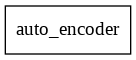

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      9249
           1       0.84      0.47      0.60      1237

    accuracy                           0.93     10486
   macro avg       0.88      0.73      0.78     10486
weighted avg       0.92      0.93      0.92     10486



In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 1, nu = 0.5).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[3420, 5829],
       [ 137, 1100]])

In [ ]:
#Modelo 21
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.01).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[3705, 5544],
       [ 189, 1048]])

In [18]:
#Para llamar y usar el modelo anteriormente guardado
import joblib
autoencoder_model3 = open('autoencoder_model3.pkl','rb')
model3 = joblib.load(autoencoder_model3)

In [ ]:
#Modelo 23
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.4).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4231, 5018],
       [ 463,  774]])

In [ ]:
#Modelo 25
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.6).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4592, 4657],
       [ 616,  621]])

In [ ]:
#Modelo 27
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.8).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4851, 4398],
       [ 736,  501]])

In [ ]:
#Modelo 26
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.55).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4858, 4391],
       [ 697,  540]])

In [ ]:
#Modelo 24
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.11, nu = 0.51).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5535, 3714],
       [ 707,  530]])

In [ ]:
#Modelo 28
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.51).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5153, 4096],
       [ 721,  516]])

In [ ]:
#Modelo 29
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.1, nu = 0.55).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4858, 4391],
       [ 697,  540]])

In [ ]:
#Modelo 30
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.75).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[2884, 6365],
       [ 257,  980]])

In [ ]:
#Modelo 31
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.0005).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4937, 4312],
       [ 650,  587]])

In [ ]:
#Modelo 32
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.5).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5979, 3270],
       [ 708,  529]])

In [ ]:
#Modelo 33
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.75).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[2884, 6365],
       [ 257,  980]])

In [ ]:
#Modelo 34
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.95).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[ 447, 8802],
       [   0, 1237]])

In [ ]:
#Modelo 35
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.3).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5479, 3770],
       [ 777,  460]])

In [ ]:
#Modelo 36
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0005, nu = 0.2).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[4923, 4326],
       [ 622,  615]])

In [ ]:
#Modelo 37
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0001, nu = 0.2).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5001, 4248],
       [ 596,  641]])

In [ ]:
#Modelo 38
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.0001, nu = 0.1).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5140, 4109],
       [ 590,  647]])

In [ ]:
#Modelo 39
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.1).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[5595, 3654],
       [ 743,  494]])

In [ ]:
#Modelo 40
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
model = OneClassSVM(kernel = 'rbf', gamma = 0.001, nu = 0.08).fit(df)
y_pred = model.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

array([[3777, 5472],
       [ 417,  820]])

In [ ]:
#Modelo 41
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix
data = pd.read_csv('muestra1.csv')
df = data[['Duration', 'SrcPt', 'Packets', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'DstPt']]
nus = [0.001, 0.01, 0.1, 1]
gammas = [0.001, 0.01, 0.1, 1]
scores = ['recall']
tuned_parameters = {'kernel': ['rbf'], 'gamma':gammas, 'nu':nus}
model = OneClassSVM()
clf=GridSearchCV(model, tuned_parameters, cv=5, scoring=scores, refit=False)
clf.fit(df)

In [ ]:
clf

In [ ]:
y_pred = clf.predict(df)
y_pred = pd.DataFrame(y_pred)
y_pred.loc[y_pred[0]==1]=0
y_pred.loc[y_pred[0]==-1]=1
y_train = data[["class"]]
confusion_matrix(y_train, y_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Epoch 1/75
125/125 [==============================] - 4s 9ms/step - loss: 0.2567 - accuracy: 0.6457 - val_loss: 0.1928 - val_accuracy: 0.9399
Epoch 2/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1921 - accuracy: 0.8996 - val_loss: 0.1886 - val_accuracy: 0.9307
Epoch 3/75
125/125 [==============================] - 1s 6ms/step - loss: 0.1886 - accuracy: 0.9067 - val_loss: 0.1869 - val_accuracy: 0.9625
Epoch 4/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1872 - accuracy: 0.9171 - val_loss: 0.1860 - val_accuracy: 0.9524
Epoch 5/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1862 - accuracy: 0.9258 - val_loss: 0.1853 - val_accuracy: 0.9605
Epoch 6/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1856 - accuracy: 0.9297 - val_loss: 0.1851 - val_accuracy: 0.9639
Epoch 7/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1852 - accuracy: 0.9361 - val_loss: 0.1850 - val_accuracy: 0.9621
Epoch 

array([[8957,  292],
       [ 700,  537]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Epoch 1/75
125/125 [==============================] - 4s 18ms/step - loss: 0.2745 - accuracy: 0.6289 - val_loss: 0.2100 - val_accuracy: 0.9097
Epoch 2/75
125/125 [==============================] - 1s 10ms/step - loss: 0.2092 - accuracy: 0.9004 - val_loss: 0.2055 - val_accuracy: 0.9558
Epoch 3/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2056 - accuracy: 0.9165 - val_loss: 0.2046 - val_accuracy: 0.9475
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2044 - accuracy: 0.9283 - val_loss: 0.2034 - val_accuracy: 0.9515
Epoch 5/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2034 - accuracy: 0.9290 - val_loss: 0.2029 - val_accuracy: 0.9437
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2027 - accuracy: 0.9364 - val_loss: 0.2025 - val_accuracy: 0.9628
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2024 - accuracy: 0.9376 - val_loss: 0.2023 - val_accuracy: 0.9545
Epoc

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


Epoch 1/75
125/125 [==============================] - 3s 12ms/step - loss: 0.2749 - accuracy: 0.5970 - val_loss: 0.2089 - val_accuracy: 0.9004
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2076 - accuracy: 0.8975 - val_loss: 0.2048 - val_accuracy: 0.9213
Epoch 3/75
125/125 [==============================] - 1s 11ms/step - loss: 0.2036 - accuracy: 0.9188 - val_loss: 0.2019 - val_accuracy: 0.9550
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2019 - accuracy: 0.9275 - val_loss: 0.2010 - val_accuracy: 0.9542
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2010 - accuracy: 0.9349 - val_loss: 0.2003 - val_accuracy: 0.9619
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2003 - accuracy: 0.9356 - val_loss: 0.2001 - val_accuracy: 0.9534
Epoch 7/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1999 - accuracy: 0.9399 - val_loss: 0.2001 - val_accuracy: 0.9581
Epoc

array([[9202,   47],
       [1116,  121]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 13ms/step - loss: 0.2518 - accuracy: 0.6679 - val_loss: 0.1962 - val_accuracy: 0.9352
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1936 - accuracy: 0.9031 - val_loss: 0.1927 - val_accuracy: 0.9487
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1908 - accuracy: 0.9169 - val_loss: 0.1918 - val_accuracy: 0.9640
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1898 - accuracy: 0.9259 - val_loss: 0.1913 - val_accuracy: 0.9590
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1892 - accuracy: 0.9359 - val_loss: 0.1908 - val_accuracy: 0.9612
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1888 - accuracy: 0.9358 - val_loss: 0.1907 - val_accuracy: 0.9700
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1886 - accuracy: 0.9387 - val_loss: 0.1907 - val_accuracy: 0.9585
Epoch

array([[9187,   62],
       [1115,  122]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 13ms/step - loss: 0.2117 - accuracy: 0.8634 - val_loss: 0.1571 - val_accuracy: 0.9983
Epoch 2/75
125/125 [==============================] - 1s 12ms/step - loss: 0.1548 - accuracy: 0.9991 - val_loss: 0.1509 - val_accuracy: 0.9988
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1513 - accuracy: 0.9994 - val_loss: 0.1496 - val_accuracy: 0.9988
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1501 - accuracy: 0.9992 - val_loss: 0.1492 - val_accuracy: 0.9985
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1495 - accuracy: 0.9991 - val_loss: 0.1490 - val_accuracy: 0.9988
Epoch 6/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1491 - accuracy: 0.9994 - val_loss: 0.1487 - val_accuracy: 0.9988
Epoch 7/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1488 - accuracy: 0.9994 - val_loss: 0.1486 - val_accuracy: 0.9989
Epoc

array([[9040,  209],
       [1151,   86]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Packets', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 15ms/step - loss: 0.2931 - accuracy: 0.5661 - val_loss: 0.2145 - val_accuracy: 0.8907
Epoch 2/75
125/125 [==============================] - 2s 12ms/step - loss: 0.2137 - accuracy: 0.8920 - val_loss: 0.2123 - val_accuracy: 0.9273
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2112 - accuracy: 0.9106 - val_loss: 0.2103 - val_accuracy: 0.9481
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2093 - accuracy: 0.9158 - val_loss: 0.2092 - val_accuracy: 0.9525
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2080 - accuracy: 0.9170 - val_loss: 0.2068 - val_accuracy: 0.9439
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2064 - accuracy: 0.9258 - val_loss: 0.2061 - val_accuracy: 0.9458
Epoch 7/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2059 - accuracy: 0.9320 - val_loss: 0.2057 - val_accuracy: 0.9485
Epoc

array([[8929,  320],
       [1089,  148]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 2s 9ms/step - loss: 0.2802 - accuracy: 0.6542 - val_loss: 0.2133 - val_accuracy: 0.9503
Epoch 2/75
125/125 [==============================] - 1s 7ms/step - loss: 0.2129 - accuracy: 0.8979 - val_loss: 0.2097 - val_accuracy: 0.9003
Epoch 3/75
125/125 [==============================] - 1s 7ms/step - loss: 0.2092 - accuracy: 0.9111 - val_loss: 0.2075 - val_accuracy: 0.9540
Epoch 4/75
125/125 [==============================] - 1s 6ms/step - loss: 0.2075 - accuracy: 0.9181 - val_loss: 0.2063 - val_accuracy: 0.9544
Epoch 5/75
125/125 [==============================] - 1s 7ms/step - loss: 0.2064 - accuracy: 0.9287 - val_loss: 0.2058 - val_accuracy: 0.9537
Epoch 6/75
125/125 [==============================] - 1s 6ms/step - loss: 0.2059 - accuracy: 0.9342 - val_loss: 0.2054 - val_accuracy: 0.9529
Epoch 7/75
125/125 [==============================] - 1s 7ms/step - loss: 0.2056 - accuracy: 0.9352 - val_loss: 0.2055 - val_accuracy: 0.9565
Epoch 

array([[9134,  115],
       [ 803,  434]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'SrcPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'SrcPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 4s 17ms/step - loss: 0.2428 - accuracy: 0.7725 - val_loss: 0.1813 - val_accuracy: 0.9662
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1805 - accuracy: 0.9421 - val_loss: 0.1762 - val_accuracy: 0.9866
Epoch 3/75
125/125 [==============================] - 1s 12ms/step - loss: 0.1776 - accuracy: 0.9525 - val_loss: 0.1745 - val_accuracy: 0.9819
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1761 - accuracy: 0.9565 - val_loss: 0.1739 - val_accuracy: 0.9809
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1754 - accuracy: 0.9647 - val_loss: 0.1736 - val_accuracy: 0.9872
Epoch 6/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1750 - accuracy: 0.9656 - val_loss: 0.1734 - val_accuracy: 0.9829
Epoch 7/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1748 - accuracy: 0.9668 - val_loss: 0.1734 - val_accuracy: 0.9821
Epoc

array([[9226,   23],
       [1151,   86]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 2s 9ms/step - loss: 0.2509 - accuracy: 0.7180 - val_loss: 0.1802 - val_accuracy: 0.9622
Epoch 2/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1805 - accuracy: 0.9458 - val_loss: 0.1770 - val_accuracy: 0.9790
Epoch 3/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1781 - accuracy: 0.9571 - val_loss: 0.1757 - val_accuracy: 0.9831
Epoch 4/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1767 - accuracy: 0.9604 - val_loss: 0.1746 - val_accuracy: 0.9850
Epoch 5/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1758 - accuracy: 0.9650 - val_loss: 0.1742 - val_accuracy: 0.9899
Epoch 6/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1753 - accuracy: 0.9683 - val_loss: 0.1741 - val_accuracy: 0.9782
Epoch 7/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1750 - accuracy: 0.9719 - val_loss: 0.1738 - val_accuracy: 0.9825
Epoch 

array([[9060,  189],
       [ 799,  438]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 14ms/step - loss: 0.2178 - accuracy: 0.6858 - val_loss: 0.1550 - val_accuracy: 0.8525
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1541 - accuracy: 0.8856 - val_loss: 0.1510 - val_accuracy: 0.9231
Epoch 3/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1506 - accuracy: 0.9001 - val_loss: 0.1474 - val_accuracy: 0.9596
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1486 - accuracy: 0.9115 - val_loss: 0.1461 - val_accuracy: 0.9681
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1476 - accuracy: 0.9183 - val_loss: 0.1455 - val_accuracy: 0.9536
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1470 - accuracy: 0.9270 - val_loss: 0.1454 - val_accuracy: 0.9537
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1467 - accuracy: 0.9244 - val_loss: 0.1453 - val_accuracy: 0.9594
Epoch

array([[9037,  212],
       [ 715,  522]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[[ 'Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Proto', 'SrcPt', 'DstPt', 'Packets','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 4s 12ms/step - loss: 0.2884 - accuracy: 0.5545 - val_loss: 0.2173 - val_accuracy: 0.7130
Epoch 2/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2132 - accuracy: 0.8438 - val_loss: 0.2098 - val_accuracy: 0.8895
Epoch 3/75
125/125 [==============================] - 1s 11ms/step - loss: 0.2077 - accuracy: 0.9128 - val_loss: 0.2054 - val_accuracy: 0.9575
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2053 - accuracy: 0.9262 - val_loss: 0.2046 - val_accuracy: 0.9516
Epoch 5/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2043 - accuracy: 0.9343 - val_loss: 0.2040 - val_accuracy: 0.9743
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2036 - accuracy: 0.9408 - val_loss: 0.2037 - val_accuracy: 0.9623
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2033 - accuracy: 0.9402 - val_loss: 0.2035 - val_accuracy: 0.9553
Epoc

array([[9219,   30],
       [1154,   83]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 2s 8ms/step - loss: 0.0793 - accuracy: 0.5717 - val_loss: 0.0169 - val_accuracy: 0.5308
Epoch 2/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0190 - accuracy: 0.5717 - val_loss: 0.0156 - val_accuracy: 0.5308
Epoch 3/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0184 - accuracy: 0.5717 - val_loss: 0.0152 - val_accuracy: 0.5308
Epoch 4/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0182 - accuracy: 0.5718 - val_loss: 0.0150 - val_accuracy: 0.5308
Epoch 5/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0180 - accuracy: 0.5717 - val_loss: 0.0150 - val_accuracy: 0.5308
Epoch 6/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0180 - accuracy: 0.5718 - val_loss: 0.0150 - val_accuracy: 0.5308
Epoch 7/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0179 - accuracy: 0.5718 - val_loss: 0.0149 - val_accuracy: 0.5308
Epoch 

array([[8540,  709],
       [1235,    2]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 11ms/step - loss: 0.0965 - accuracy: 0.5970 - val_loss: 0.0233 - val_accuracy: 0.6876
Epoch 2/75
125/125 [==============================] - 1s 8ms/step - loss: 0.0251 - accuracy: 0.6640 - val_loss: 0.0224 - val_accuracy: 0.7219
Epoch 3/75
125/125 [==============================] - 1s 8ms/step - loss: 0.0243 - accuracy: 0.7159 - val_loss: 0.0218 - val_accuracy: 0.7589
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.0229 - accuracy: 0.8084 - val_loss: 0.0202 - val_accuracy: 0.8560
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.0222 - accuracy: 0.8924 - val_loss: 0.0201 - val_accuracy: 0.9327
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.0219 - accuracy: 0.9301 - val_loss: 0.0201 - val_accuracy: 0.9898
Epoch 7/75
125/125 [==============================] - 1s 8ms/step - loss: 0.0220 - accuracy: 0.9339 - val_loss: 0.0201 - val_accuracy: 0.9148
Epoch

array([[9200,   49],
       [1237,    0]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

Epoch 1/75
125/125 [==============================] - 2s 8ms/step - loss: 0.1037 - accuracy: 0.5746 - val_loss: 0.0331 - val_accuracy: 0.6431
Epoch 2/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0348 - accuracy: 0.6140 - val_loss: 0.0320 - val_accuracy: 0.6440
Epoch 3/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0343 - accuracy: 0.6151 - val_loss: 0.0317 - val_accuracy: 0.6450
Epoch 4/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0334 - accuracy: 0.6785 - val_loss: 0.0298 - val_accuracy: 0.7310
Epoch 5/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0313 - accuracy: 0.8886 - val_loss: 0.0293 - val_accuracy: 0.8603
Epoch 6/75
125/125 [==============================] - 1s 6ms/step - loss: 0.0311 - accuracy: 0.8929 - val_loss: 0.0291 - val_accuracy: 0.9316
Epoch 7/75
125/125 [==============================] - 1s 7ms/step - loss: 0.0310 - accuracy: 0.9021 - val_loss: 0.0292 - val_accuracy: 0.8815
Epoch 

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 13ms/step - loss: 0.1320 - accuracy: 0.3488 - val_loss: 0.0593 - val_accuracy: 0.7621
Epoch 2/75
125/125 [==============================] - 1s 8ms/step - loss: 0.0649 - accuracy: 0.7418 - val_loss: 0.0572 - val_accuracy: 0.7625
Epoch 3/75
125/125 [==============================] - 1s 8ms/step - loss: 0.0642 - accuracy: 0.7464 - val_loss: 0.0570 - val_accuracy: 0.7623
Epoch 4/75
125/125 [==============================] - 1s 10ms/step - loss: 0.0639 - accuracy: 0.7463 - val_loss: 0.0567 - val_accuracy: 0.7623
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.0632 - accuracy: 0.8215 - val_loss: 0.0555 - val_accuracy: 0.8428
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.0618 - accuracy: 0.9116 - val_loss: 0.0548 - val_accuracy: 0.8855
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.0616 - accuracy: 0.9168 - val_loss: 0.0548 - val_accuracy: 0.9005
Epoc

array([[9201,   48],
       [1235,    2]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 2s 9ms/step - loss: 0.2221 - accuracy: 0.8710 - val_loss: 0.1543 - val_accuracy: 0.9455
Epoch 2/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1573 - accuracy: 0.9416 - val_loss: 0.1487 - val_accuracy: 0.9516
Epoch 3/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1543 - accuracy: 0.9504 - val_loss: 0.1478 - val_accuracy: 0.9525
Epoch 4/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1537 - accuracy: 0.9522 - val_loss: 0.1475 - val_accuracy: 0.9614
Epoch 5/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1533 - accuracy: 0.9533 - val_loss: 0.1475 - val_accuracy: 0.9525
Epoch 6/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1530 - accuracy: 0.9543 - val_loss: 0.1471 - val_accuracy: 0.9616
Epoch 7/75
125/125 [==============================] - 1s 7ms/step - loss: 0.1527 - accuracy: 0.9569 - val_loss: 0.1471 - val_accuracy: 0.9618
Epoch 

array([[9216,   33],
       [1235,    2]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration','Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 12ms/step - loss: 0.1918 - accuracy: 0.8754 - val_loss: 0.1291 - val_accuracy: 0.9473
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1324 - accuracy: 0.9377 - val_loss: 0.1240 - val_accuracy: 0.9504
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1289 - accuracy: 0.9453 - val_loss: 0.1235 - val_accuracy: 0.9525
Epoch 4/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1283 - accuracy: 0.9496 - val_loss: 0.1233 - val_accuracy: 0.9525
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1279 - accuracy: 0.9512 - val_loss: 0.1229 - val_accuracy: 0.9516
Epoch 6/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1277 - accuracy: 0.9538 - val_loss: 0.1228 - val_accuracy: 0.9618
Epoch 7/75
125/125 [==============================] - 1s 12ms/step - loss: 0.1275 - accuracy: 0.9559 - val_loss: 0.1225 - val_accuracy: 0.9618
Epoc

array([[9130,  119],
       [1050,  187]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 15ms/step - loss: 0.2336 - accuracy: 0.7009 - val_loss: 0.1515 - val_accuracy: 0.9406
Epoch 2/75
125/125 [==============================] - 2s 14ms/step - loss: 0.1545 - accuracy: 0.9106 - val_loss: 0.1486 - val_accuracy: 0.9549
Epoch 3/75
125/125 [==============================] - 2s 15ms/step - loss: 0.1521 - accuracy: 0.9313 - val_loss: 0.1480 - val_accuracy: 0.9520
Epoch 4/75
125/125 [==============================] - 2s 14ms/step - loss: 0.1507 - accuracy: 0.9348 - val_loss: 0.1467 - val_accuracy: 0.9446
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1497 - accuracy: 0.9419 - val_loss: 0.1460 - val_accuracy: 0.9482
Epoch 6/75
125/125 [==============================] - 1s 8ms/step - loss: 0.1492 - accuracy: 0.9466 - val_loss: 0.1457 - val_accuracy: 0.9608
Epoch 7/75
125/125 [==============================] - 1s 12ms/step - loss: 0.1489 - accuracy: 0.9483 - val_loss: 0.1455 - val_accuracy: 0.9651
E

array([[8940,  309],
       [ 591,  646]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'SrcPt', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'SrcPt', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 6s 18ms/step - loss: 0.2348 - accuracy: 0.6786 - val_loss: 0.1741 - val_accuracy: 0.8768
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1716 - accuracy: 0.8774 - val_loss: 0.1665 - val_accuracy: 0.9332
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1682 - accuracy: 0.9014 - val_loss: 0.1652 - val_accuracy: 0.9544
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1668 - accuracy: 0.9130 - val_loss: 0.1642 - val_accuracy: 0.9565
Epoch 5/75
125/125 [==============================] - 2s 12ms/step - loss: 0.1657 - accuracy: 0.9198 - val_loss: 0.1635 - val_accuracy: 0.9526
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1652 - accuracy: 0.9196 - val_loss: 0.1632 - val_accuracy: 0.9494
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1648 - accuracy: 0.9244 - val_loss: 0.1631 - val_accuracy: 0.9526
Epoc

array([[9093,  156],
       [1098,  139]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Packets', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Packets', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 12ms/step - loss: 0.2047 - accuracy: 0.7273 - val_loss: 0.1335 - val_accuracy: 0.9289
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1353 - accuracy: 0.9131 - val_loss: 0.1301 - val_accuracy: 0.9595
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1330 - accuracy: 0.9308 - val_loss: 0.1293 - val_accuracy: 0.9510
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1316 - accuracy: 0.9379 - val_loss: 0.1282 - val_accuracy: 0.9634
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1309 - accuracy: 0.9454 - val_loss: 0.1277 - val_accuracy: 0.9643
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1305 - accuracy: 0.9442 - val_loss: 0.1276 - val_accuracy: 0.9588
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1303 - accuracy: 0.9479 - val_loss: 0.1274 - val_accuracy: 0.9618
Epoch

array([[9162,   87],
       [1127,  110]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 13ms/step - loss: 0.2646 - accuracy: 0.7582 - val_loss: 0.2012 - val_accuracy: 0.9652
Epoch 2/75
125/125 [==============================] - 1s 10ms/step - loss: 0.2022 - accuracy: 0.9477 - val_loss: 0.1989 - val_accuracy: 0.9510
Epoch 3/75
125/125 [==============================] - 1s 10ms/step - loss: 0.2001 - accuracy: 0.9539 - val_loss: 0.1980 - val_accuracy: 0.9681
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1989 - accuracy: 0.9597 - val_loss: 0.1968 - val_accuracy: 0.9832
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1979 - accuracy: 0.9636 - val_loss: 0.1958 - val_accuracy: 0.9810
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1971 - accuracy: 0.9648 - val_loss: 0.1955 - val_accuracy: 0.9823
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.1967 - accuracy: 0.9689 - val_loss: 0.1953 - val_accuracy: 0.9784
Epo

array([[9039,  210],
       [ 546,  691]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'Hour']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'Hour']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 14ms/step - loss: 0.3087 - accuracy: 0.6404 - val_loss: 0.2079 - val_accuracy: 0.6972
Epoch 2/75
125/125 [==============================] - 1s 10ms/step - loss: 0.2539 - accuracy: 0.8759 - val_loss: 0.0634 - val_accuracy: 0.8783
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2501 - accuracy: 0.9155 - val_loss: 0.0192 - val_accuracy: 0.9181
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2487 - accuracy: 0.9243 - val_loss: -4.5234e-04 - val_accuracy: 0.9378
Epoch 5/75
125/125 [==============================] - 2s 14ms/step - loss: 0.2476 - accuracy: 0.9347 - val_loss: -0.0324 - val_accuracy: 0.9352
Epoch 6/75
125/125 [==============================] - 2s 13ms/step - loss: 0.2469 - accuracy: 0.9391 - val_loss: -0.0482 - val_accuracy: 0.9419
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2465 - accuracy: 0.9454 - val_loss: -0.0467 - val_accuracy: 0

array([[3050, 6199],
       [ 221, 1016]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'Min']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'Min']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 13ms/step - loss: 0.3164 - accuracy: 0.5806 - val_loss: 0.2399 - val_accuracy: 0.9352
Epoch 2/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2403 - accuracy: 0.8984 - val_loss: 0.2334 - val_accuracy: 0.9500
Epoch 3/75
125/125 [==============================] - 2s 12ms/step - loss: 0.2365 - accuracy: 0.9192 - val_loss: 0.2312 - val_accuracy: 0.9623
Epoch 4/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2349 - accuracy: 0.9242 - val_loss: 0.2303 - val_accuracy: 0.9548
Epoch 5/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2338 - accuracy: 0.9290 - val_loss: 0.2295 - val_accuracy: 0.9681
Epoch 6/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2330 - accuracy: 0.9350 - val_loss: 0.2291 - val_accuracy: 0.9612
Epoch 7/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2326 - accuracy: 0.9369 - val_loss: 0.2287 - val_accuracy: 0.9667
Epoc

array([[8984,  265],
       [ 639,  598]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'Sec']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed', 'Sec']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=75,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/75
125/125 [==============================] - 3s 11ms/step - loss: 0.3047 - accuracy: 0.6277 - val_loss: 0.2108 - val_accuracy: 0.9300
Epoch 2/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2382 - accuracy: 0.9046 - val_loss: 0.2068 - val_accuracy: 0.9712
Epoch 3/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2353 - accuracy: 0.9210 - val_loss: 0.2051 - val_accuracy: 0.9836
Epoch 4/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2333 - accuracy: 0.9226 - val_loss: 0.2036 - val_accuracy: 0.9725
Epoch 5/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2322 - accuracy: 0.9310 - val_loss: 0.2028 - val_accuracy: 0.9778
Epoch 6/75
125/125 [==============================] - 1s 8ms/step - loss: 0.2315 - accuracy: 0.9324 - val_loss: 0.2024 - val_accuracy: 0.9601
Epoch 7/75
125/125 [==============================] - 1s 9ms/step - loss: 0.2310 - accuracy: 0.9382 - val_loss: 0.2020 - val_accuracy: 0.9829
Epoch

array([[9084,  165],
       [1024,  213]])

In [ ]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units
  
  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=10):
    super().__init__()
    self.encoder = Sequential([
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(code_size, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(128, activation='relu'),
      Dropout(0.1),
      Dense(256, activation='relu'),
      Dropout(0.1),
      Dense(512, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded
  
model = AutoEncoder(output_units=x_train_scaled.shape[1])
# configurations of model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=500,
    batch_size=128,
    validation_data=(x_test_scaled, x_test_scaled)
)

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")
# Threshold: 0.01001314025746261

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

Epoch 1/500
125/125 [==============================] - 2s 9ms/step - loss: 0.2709 - accuracy: 0.7314 - val_loss: 0.2022 - val_accuracy: 0.9813
Epoch 2/500
125/125 [==============================] - 1s 7ms/step - loss: 0.2023 - accuracy: 0.9523 - val_loss: 0.1986 - val_accuracy: 0.9761
Epoch 3/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1998 - accuracy: 0.9610 - val_loss: 0.1974 - val_accuracy: 0.9789
Epoch 4/500
125/125 [==============================] - 1s 6ms/step - loss: 0.1984 - accuracy: 0.9646 - val_loss: 0.1960 - val_accuracy: 0.9763
Epoch 5/500
125/125 [==============================] - 1s 6ms/step - loss: 0.1974 - accuracy: 0.9656 - val_loss: 0.1955 - val_accuracy: 0.9852
Epoch 6/500
125/125 [==============================] - 1s 6ms/step - loss: 0.1970 - accuracy: 0.9689 - val_loss: 0.1953 - val_accuracy: 0.9838
Epoch 7/500
125/125 [==============================] - 1s 7ms/step - loss: 0.1966 - accuracy: 0.9688 - val_loss: 0.1953 - val_accuracy: 0.9775

array([[8931,  318],
       [ 458,  779]])

In [ ]:
print(f"Threshold: {threshold}")

Threshold: 2.834330835351992e-05


In [ ]:
import joblib
joblib.dump(model, 'autoencoder_model3.pkl')

INFO:tensorflow:Assets written to: ram://026345bc-f38d-4f75-abb8-ee4c225c1ccd/assets


['autoencoder_model3.pkl']

In [ ]:
import joblib
autoencoder_model3 = open('autoencoder_model3.pkl','rb')
model3 = joblib.load(autoencoder_model3)

df = pd.read_csv('muestra1.csv')
X_test = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled = min_max_scaler.fit_transform(X_test.copy())
x_test_scaled = min_max_scaler.transform(X_test.copy())
Y_test = pd.DataFrame(df[['class']]) 
#result = model1.score(X_test, Y_test)
threshold = find_threshold(model3, x_train_scaled)

predictions = model.predict(x_test_scaled)
errors = tf.keras.losses.msle(predictions, x_test_scaled)
anomaly_mask = pd.Series(errors) > threshold
preds = anomaly_mask.map(lambda x: 1 if x == True else 0)

predictions = get_predictions(model3, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

0.8944306694640473

In [21]:
df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
x_train = datos_X
y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
x_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(x_train.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

#funciones necesarias
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  # provides losses of individual instances
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  # threshold for anomaly scores
  threshold = np.mean(reconstruction_errors.numpy()) \
      + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  # provides losses of individual instances
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  # 1 = anomaly, 0 = normal
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1 if x == True else 0)
  return preds

  
import joblib
autoencoder_model3 = open('autoencoder_model3.pkl','rb')
model = joblib.load(autoencoder_model3)

df = pd.read_csv('muestra1.csv')
X_test = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_test_scaled = min_max_scaler.fit_transform(X_test.copy())
x_test_scaled = min_max_scaler.transform(X_test.copy())
Y_test = pd.DataFrame(df[['class']]) 
#result = model1.score(X_test, Y_test)
threshold = find_threshold(model3, x_train_scaled)

predictions = model.predict(x_test_scaled)
errors = tf.keras.losses.msle(predictions, x_test_scaled)
anomaly_mask = pd.Series(errors) > threshold
preds = anomaly_mask.map(lambda x: 1 if x == True else 0)

predictions = get_predictions(model, x_test_scaled, threshold)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0:'class_pred'})
y_test = y_test.rename(columns={1:'class'})
y_test["class"] = y_test["class"].astype(str).astype(int)

accuracy_score(predictions, y_test)

0.8944306694640473

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[8613,  636],
       [ 471,  766]])

In [ ]:
import joblib
autoencoder_model3 = open('autoencoder_model3.pkl','rb')
model3 = joblib.load(autoencoder_model3)

df = pd.read_csv('train_CIDDS.csv')
datos_X = pd.DataFrame(df[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
datos_y = pd.DataFrame(df[['class']])
X_train = datos_X
Y_train = datos_y

df1 = pd.read_csv("muestra1.csv")
#df1 = df1.head(1)
df1 = df1.iloc[10483:10484]
X_test = pd.DataFrame(df1[['Duration', 'Proto', 'DstPt', 'Bytes', 'Flags', 'Tos', 'Packets_speed', 'Bytes_speed']])
Y_test = pd.DataFrame(df1[['class']])

min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(X_train.copy())
x_test_scaled = min_max_scaler.transform(X_test.copy())
threshold = find_threshold(model3, x_train_scaled)

predictions = model.predict(x_test_scaled)
errors = tf.keras.losses.msle(predictions, x_test_scaled)
anomaly_mask = pd.Series(errors) > threshold
preds = anomaly_mask.map(lambda x: 1 if x == True else 0)

predictions = get_predictions(model3, x_test_scaled, threshold)
if predictions[0] == 1:
  print("Test traffic flow predicted to be Anomalous")
else:
  print("Test traffic flow predicted to be Normal")

Test traffic flow predicted to be Anomalous


In [ ]:

#accuracy_score(predictions, Y_test)

Test traffic flow predicted to be Normal


In [ ]:
df1 = pd.read_csv("muestra1.csv")
df1 = df1.tail(5)
df1

,Unnamed: 0,Duration,Proto,SrcPt,DstPt,Packets,Bytes,Flags,Tos,class,Packets_speed,Bytes_speed,Hour,Min,Sec
10481,10482,0.004,6,80,34700.0,3,206.0,19,0,1,750.000000,51500.000000,8,19,6
10482,10483,0.003,6,33810,80.0,5,479.0,27,0,1,1666.666667,159666.666667,8,17,3
10483,10484,0.000,6,46755,995.0,1,58.0,2,0,1,10000.000000,580000.000000,55,55,4
10484,10485,0.003,6,80,59546.0,4,272.0,19,0,1,1333.333333,90666.666667,41,44,4
10485,10486,0.006,6,35289,80.0,5,479.0,27,0,1,833.333333,79833.333333,8,20,9


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, predictions)

array([[8931,  318],
       [ 458,  779]])